In [1]:
import sys
import os

sys.path.append(os.path.abspath("../"))

In [2]:
from huggingface_hub import hf_hub_download

# Local directory where you want the checkpoint saved
save_path = "../checkpoints/segmentation"
os.makedirs(save_path, exist_ok=True)

# Download the file
checkpoint_path = hf_hub_download(
    repo_id="SemilleroCV/transunet-breast-cancer",
    filename="lucky-sweep-6_0.4937.pth",
    local_dir=save_path
)

lucky-sweep-6_0.4937.pth:   0%|          | 0.00/421M [00:00<?, ?B/s]

In [3]:
import torch
import torch.nn as nn
from transunet.vit_seg_modeling import VisionTransformer as ViT_seg
from transunet.vit_seg_modeling import CONFIGS
from torchvision import transforms

In [4]:
class SegmentationModel(nn.Module):
    def __init__(self, img_size: int, n_skip: int, num_classes: int, dir_model: str, device: torch.device, threshold: float = 0.5):
        """
        Initializes the segmentation model with a Vision Transformer (ViT) backbone.
        
        Args:
            img_size (int): The size of the input images.
            n_skip (int): The number of skip connections.
            num_classes (int): Number of segmentation classes.
            dir_model (str): Path to the model weights file.
            device (torch.device): The device on which to load the model (CPU or GPU).
            threshold (float, optional): Threshold for converting probabilities into binary predictions. Defaults to 0.5.
        """
        super().__init__()

        self.device = device
        self.threshold = threshold

        # Fixed configuration; you can try other configurations like "ViT-B_16".
        self.config_vit = CONFIGS["R50-ViT-B_16"]  # You can try others like "ViT-B_16"
        self.config_vit.n_classes = num_classes  # Number of classes for binary segmentation
        self.config_vit.n_skip = n_skip
        self.config_vit.patches.grid = (14, 14)

        # Initialize the segmentation model using ViT_seg
        self.model = ViT_seg(self.config_vit, img_size=img_size, num_classes=num_classes).to(device)

        # Load model weights from file, mapping to the specified device
        try:
            self.model.load_state_dict(torch.load(dir_model, map_location=device))
            print(f"✅ Weights loaded from {dir_model}")
        except Exception as e:
            print(f"Error loading weights from {dir_model}: {e}")
            raise

    def forward(self, x):
        return self.model(x)

    def predict_on_image(self, image_tensor: torch.Tensor) -> torch.Tensor:
        """
        Performs prediction on a single image.
        
        Args:
            image_tensor (torch.Tensor): Input image tensor expected to have shape [1, C, H, W].
        
        Returns:
            torch.Tensor: Binary segmentation prediction with shape [C, H, W].
        """
        self.model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            image_tensor = image_tensor.to(self.device)  # Move the tensor to the appropriate device
            logits = self.model(image_tensor)             # Forward pass; output shape: [1, C, H, W]
            probs = torch.sigmoid(logits)                   # Convert logits to probabilities using sigmoid

            # Convert probabilities to binary mask using the defined threshold
            preds = (probs > self.threshold).float()
            # Squeeze the batch dimension (assumes batch size is 1)
            return preds.squeeze(0)

In [6]:
img_size = 224
device = "cuda" if torch.cuda.is_available() else "cpu"
dir_model = "../checkpoints/segmentation/lucky-sweep-6_0.4937.pth"
segmentador = SegmentationModel(img_size, 3, 1, dir_model, device, threshold=0.5)

✅ Weights loaded from ../checkpoints/segmentation/lucky-sweep-6_0.4937.pth


In [8]:
# Min-max normalization to [0, 1] for floating-point TIFFs
min_max_norm = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8))

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        min_max_norm,
    ]
)

## outputs on BreastThermography

In [1]:
from datasets import load_dataset

dataset = load_dataset("SemilleroCV/BreastThermography", revision="6a84021f2a5b253d0da72f7948de93613fd9a788")

train_val_split = 0.15

# If we don't have a validation split, split off a percentage of train as validation.
train_val_split = None if "validation" in dataset.keys() else train_val_split
if isinstance(train_val_split, float) and train_val_split > 0.0:
    split = dataset["train"].train_test_split(train_val_split, seed=0)
    dataset["train"] = split["train"]
    dataset["validation"] = split["test"]

validation_set = dataset["validation"]

print(f"validation split size: {len(validation_set)}")

Using the latest cached version of the dataset since SemilleroCV/BreastThermography couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /teamspace/studios/this_studio/.cache/huggingface/datasets/SemilleroCV___breast_thermography/default/0.0.0/6a84021f2a5b253d0da72f7948de93613fd9a788 (last modified on Mon Jul 28 16:21:39 2025).


validation split size: 43


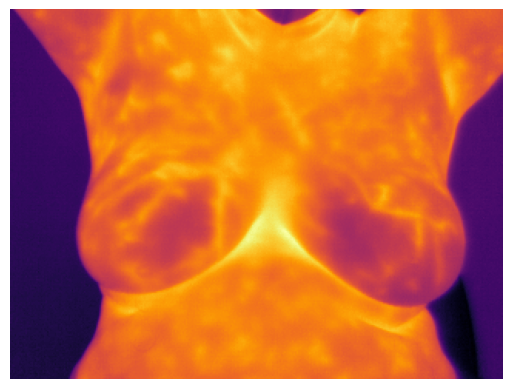

In [21]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load a sample image from the dataset
img = validation_set[42]['image']  # Select the desired image
img = np.array(img, dtype=np.float32)

# Apply the colormap and save the image
plt.imshow(img, cmap="inferno")  # Apply the 'inferno' colormap
plt.axis('off')  # Remove axes for a clean image
plt.show()

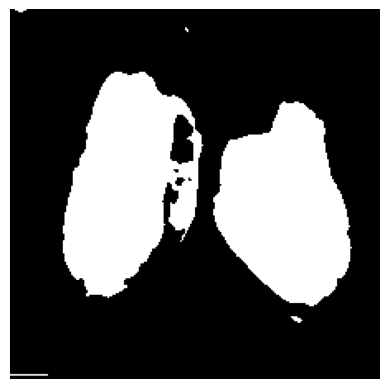

In [23]:
# Perform segmentation on the image
matrix = Image.fromarray(img)  # Convert numpy array to PIL image
matrix = val_transforms(matrix)  # Apply transformations
matrix = matrix.unsqueeze(0)  # Add batch dimension

# Get the segmentation output
output = segmentador.predict_on_image(matrix)

# Convert the output to a numpy array
output_np = output.cpu().squeeze(0).numpy()  # Remove batch dimension and convert to numpy

# Save the segmentation output with a colormap
plt.imshow(output_np, cmap='gray')  # Apply the 'inferno' colormap
plt.axis('off')  # Remove axes for a clean image
plt.show()

In [28]:
def plot_many_masks(dataset, num_images=25, cols=5):
    rows = (num_images + cols - 1) // cols  # Compute required rows
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

    for i in range(num_images):
        sample = dataset[i]['image']
        matrix = val_transforms(sample)
        matrix = matrix.unsqueeze(0)
        mask = segmentador.predict_on_image(matrix).cpu().squeeze(0).numpy()

        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        ax.imshow(mask, cmap='gray')
        ax.set_title(f"Image {i}")
        ax.axis('off')

    # Hide unused subplots (if num_images doesn't fill the grid)
    for j in range(num_images, rows * cols):
        ax = axes[j // cols, j % cols] if rows > 1 else axes[j % cols]
        ax.axis('off')

    plt.tight_layout()
    plt.show()

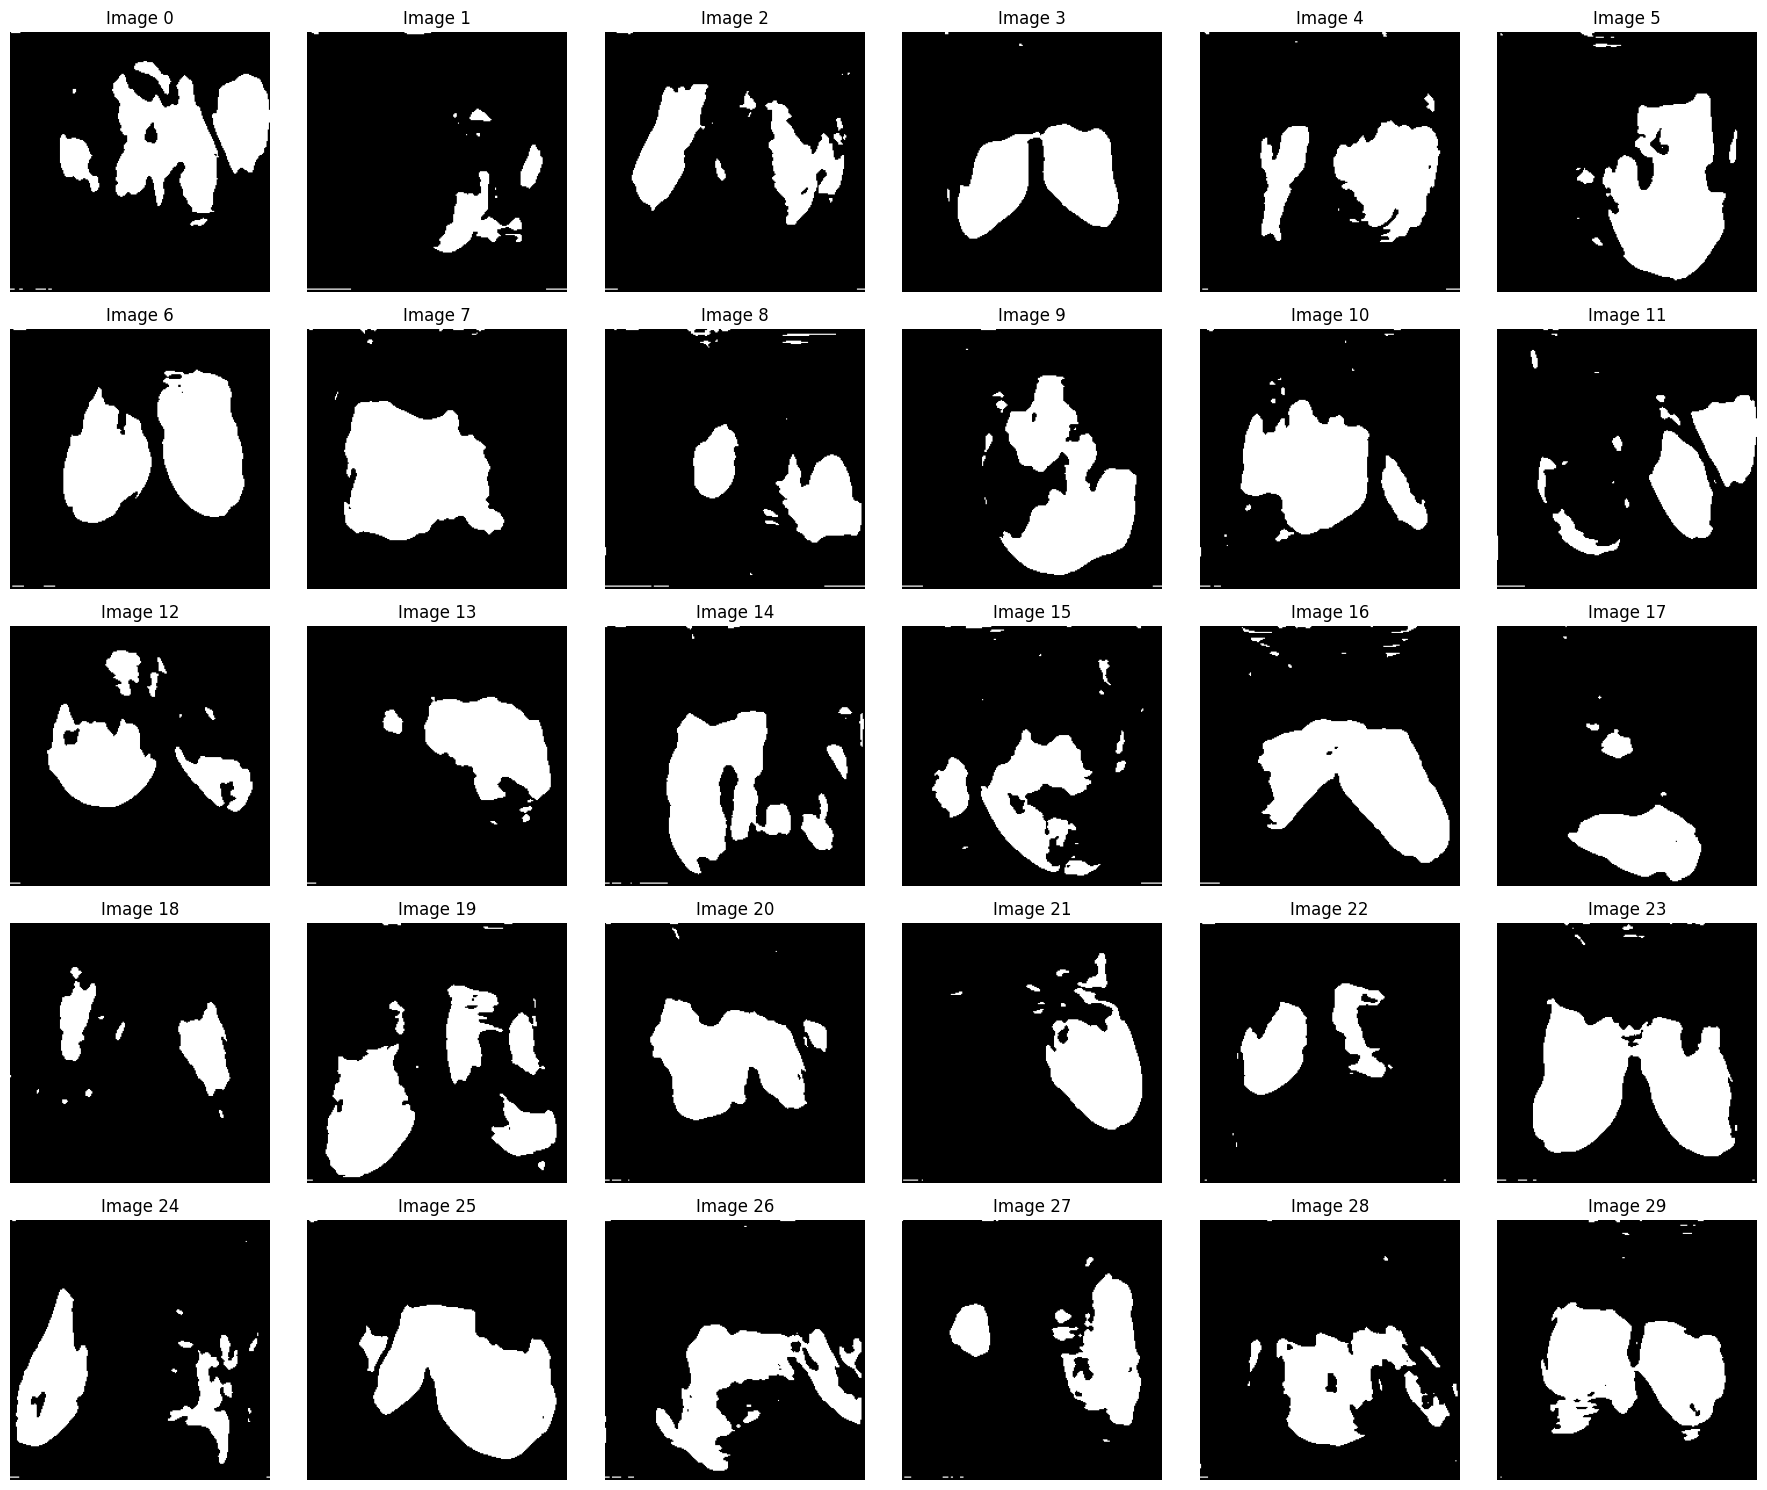

In [29]:
plot_many_masks(validation_set, num_images=30, cols=6)

In [39]:
def plot_inputs_and_masks(dataset, num_images=10, cols=5):
    """
    Plot original images alongside their predicted segmentation masks.
    
    Args:
        dataset: Hugging Face dataset with 'image' key.
        num_images: Number of samples to display.
        cols: Number of columns in the grid (each sample takes two columns: image + mask).
    """
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows * 2, cols, figsize=(3 * cols, 3 * rows))

    for idx in range(num_images):
        sample = dataset[idx]['image']
        input_tensor = val_transforms(sample).unsqueeze(0)  # [1, C, H, W]
        mask = segmentador.predict_on_image(input_tensor).cpu().squeeze(0).numpy()

        row, col = divmod(idx, cols)

        # Original image
        ax_img = axes[row * 2][col] if rows > 1 else axes[0][col]
        ax_img.imshow(input_tensor.squeeze(0).squeeze(0), cmap='inferno')
        ax_img.axis('off')

        # Predicted mask
        ax_mask = axes[row * 2 + 1][col] if rows > 1 else axes[1][col]
        ax_mask.imshow(mask, cmap='gray')
        ax_mask.axis('off')

    # Hide any unused axes
    total_plots = rows * cols
    for j in range(num_images, total_plots):
        if rows > 1:
            axes[(j // cols) * 2][j % cols].axis('off')
            axes[(j // cols) * 2 + 1][j % cols].axis('off')
        else:
            axes[0][j % cols].axis('off')
            axes[1][j % cols].axis('off')

    plt.tight_layout()
    plt.show()


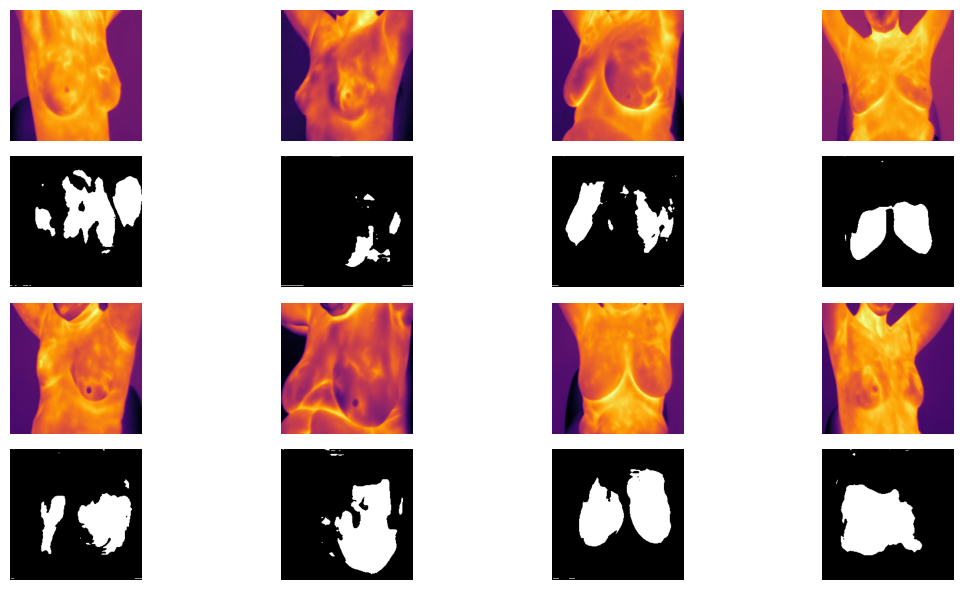

In [44]:
plot_inputs_and_masks(validation_set, num_images=8, cols=4)

In [45]:
import matplotlib.pyplot as plt

def plot_inputs_and_masks_horizontal(dataset, num_images=10, pairs_per_row=5):
    """
    Plot original images alongside their predicted segmentation masks (horizontal pairing).

    Args:
        dataset: Hugging Face dataset with 'image' key.
        num_images: Total number of image-mask pairs to display.
        pairs_per_row: Number of pairs (image+mask) per row.
    """
    rows = (num_images + pairs_per_row - 1) // pairs_per_row
    cols = pairs_per_row * 2  # Each pair takes two columns: image + mask
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

    for idx in range(num_images):
        sample = dataset[idx]['image']
        input_tensor = val_transforms(sample).unsqueeze(0)
        mask = segmentador.predict_on_image(input_tensor).cpu().squeeze(0).numpy()

        row = idx // pairs_per_row
        col_base = (idx % pairs_per_row) * 2

        # Original image
        ax_img = axes[row][col_base] if rows > 1 else axes[col_base]
        ax_img.imshow(input_tensor.squeeze(0).squeeze(0), cmap='inferno')
        ax_img.axis('off')

        # Predicted mask
        ax_mask = axes[row][col_base + 1] if rows > 1 else axes[col_base + 1]
        ax_mask.imshow(mask, cmap='gray')
        ax_mask.axis('off')

    # Hide unused axes
    total_cells = rows * cols
    for j in range(num_images * 2, total_cells):
        if rows > 1:
            axes[j // cols][j % cols].axis('off')
        else:
            axes[j].axis('off')

    plt.tight_layout()
    plt.show()

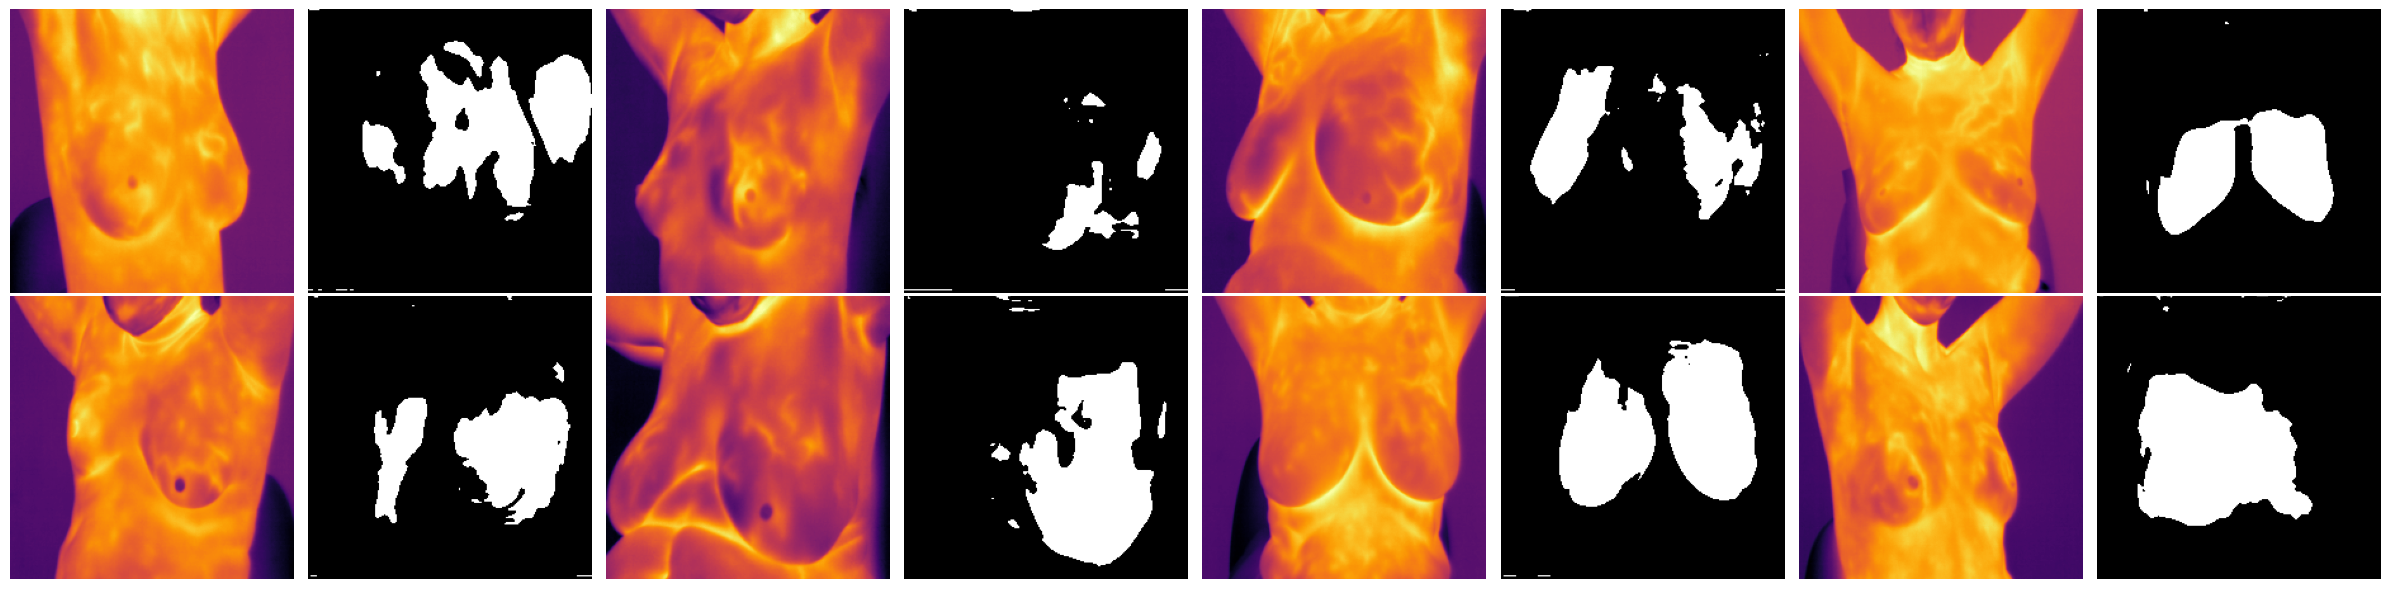

In [46]:
plot_inputs_and_masks_horizontal(validation_set, num_images=8, pairs_per_row=4)

## outputs on DMR-IR

In [ ]:
from datasets import load_dataset

dataset = load_dataset("SemilleroCV/DMR-IR", revision="69ffd6240b4a50bc4a05c59b70773f3a506054f2")

train_val_split = 0.15

# If we don't have a validation split, split off a percentage of train as validation.
train_val_split = None if "validation" in dataset.keys() else train_val_split
if isinstance(train_val_split, float) and train_val_split > 0.0:
    split = dataset["train"].train_test_split(train_val_split, seed=0)
    dataset["train"] = split["train"]
    dataset["validation"] = split["test"]

print(f"validation split size: {len(dataset['validation'])}")

validation split size: 850


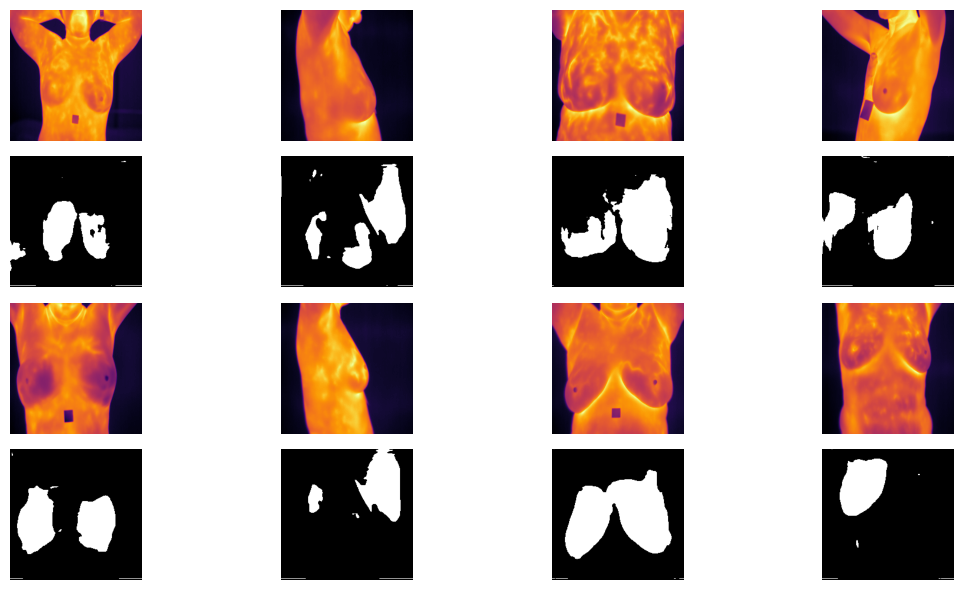

In [50]:
plot_inputs_and_masks(dataset['validation'], num_images=8, cols=4)

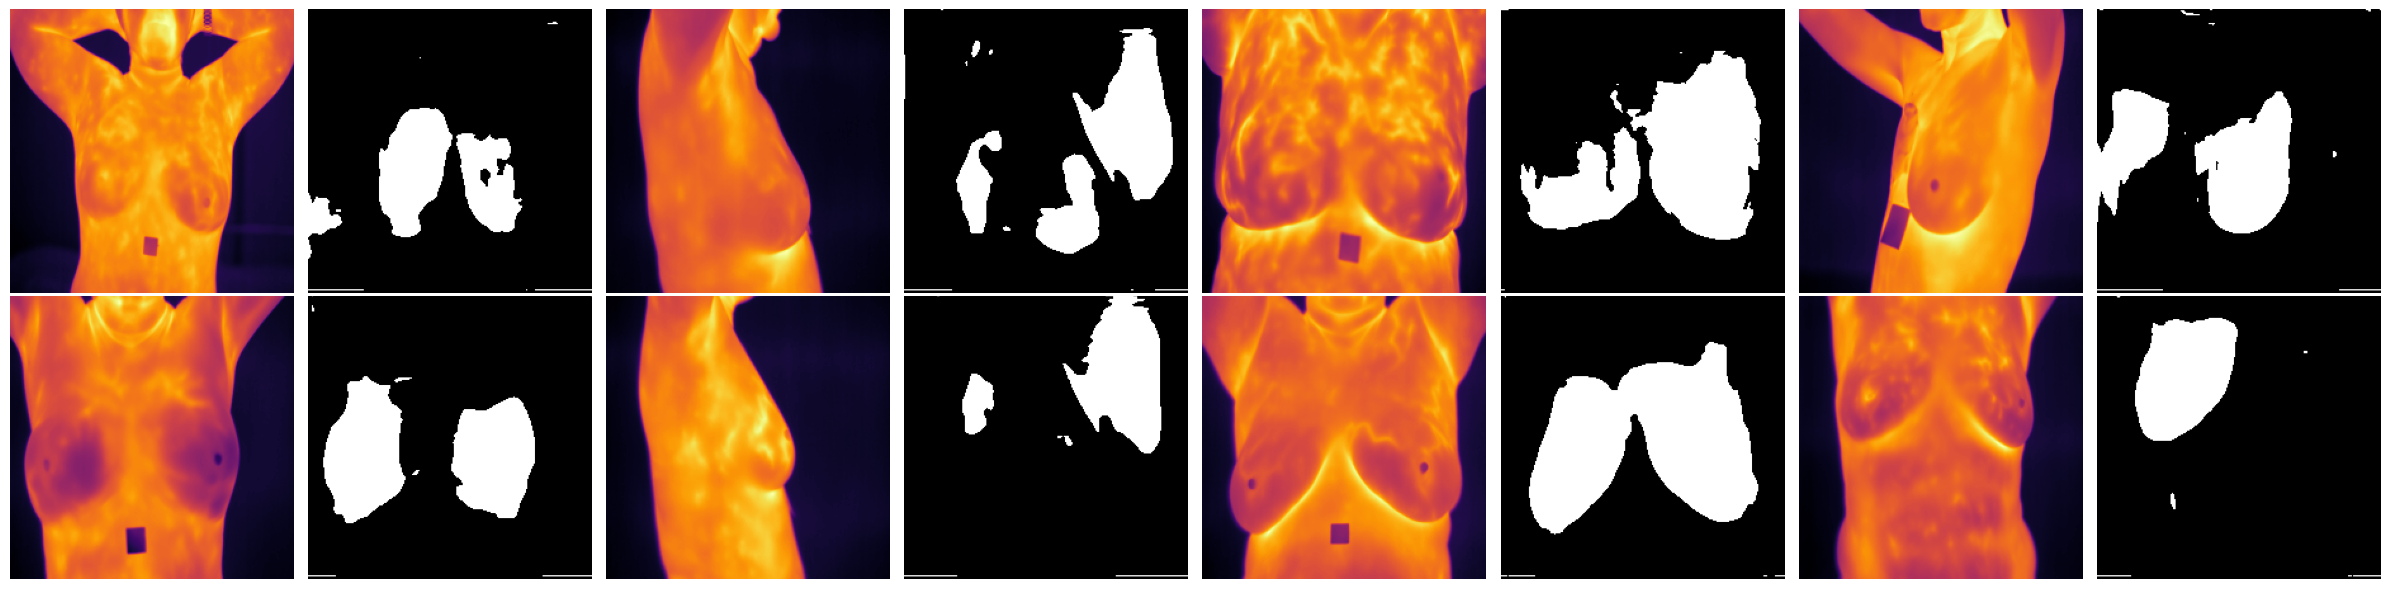

In [51]:
plot_inputs_and_masks_horizontal(dataset['validation'], num_images=8, pairs_per_row=4)